## Word Embedding

### 영어 Word2Vec 만들기

In [1]:
import re
import urllib.request
import zipfile
from lxml import etree
from nltk.tokenize import word_tokenize, sent_tokenize

#### 훈련 데이터 이해하기

In [2]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/09.%20Word%20Embedding/dataset/ted_en-20160408.xml", filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x7f0eb44df490>)

- 전처리가 필요
- 얻고자 하는 실질적 데이터는 영어문장으로만 구성된 내용을 담고 있는 <content>와 </content> 사이의 내용
- 전처리 작업을 통해 xml 문법들은 제거하고, 해당 데이터만 가져와야
- (Laughter)나 (Applause)와 같은 배경음을 나타내는 단어도 등장하는데 이 또한 제거

#### 훈련 데이터 전처리하기

In [6]:
targetXML = open('ted_en-20160408.xml', 'r', encoding='UTF8')
target_text = etree.parse(targetXML)

# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

In [7]:
print('총 샘플의 개수: {}'.format(len(result)))

총 샘플의 개수: 273424


In [8]:
# 샘플 3개만 출력
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


#### Word2Vec 훈련시키기

In [11]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [13]:
model = Word2Vec(sentences=result, vector_size=100, window=5, min_count=5, workers=4, sg=0)

vector_size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.  
window = 컨텍스트 윈도우 크기  
min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)  
workers = 학습을 위한 프로세스 수  
sg = 0은 CBOW, 1은 Skip-gram.  

In [14]:
# 가장 유사한 단어들을 출력하는 wv.most_similar 지원
model_result = model.wv.most_similar("man")
print(model_result) # man과 유사한 단어

[('woman', 0.8323533535003662), ('guy', 0.8004978895187378), ('boy', 0.7670837044715881), ('lady', 0.7613211274147034), ('soldier', 0.7343931198120117), ('gentleman', 0.7316173315048218), ('girl', 0.7272654175758362), ('kid', 0.7174754738807678), ('poet', 0.6694046258926392), ('horse', 0.6692858338356018)]


#### Word2Vec 모델 저장하고 로드하기

In [15]:
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format('eng_w2v') # 모델 로드

### 한국어 Word2Vec 만들기 (네이버 영화리뷰)

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [18]:
# 영화리뷰 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f0ea8c6e8b0>)

In [19]:
train_data = pd.read_table('ratings.txt')
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [20]:
print(len(train_data))

200000


In [21]:
# 결측값 유무 확인
print(train_data.isnull().values.any())

True


In [23]:
# 결측값 존재하는 행 제거
train_data = train_data.dropna(how='any')
print(train_data.isnull().values.any())

False


In [24]:
# 결측값 삭제 후 리뷰 개수
print(len(train_data))

199992


In [25]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

<ipython-input-25-d10eedfa8951>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [26]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [29]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업
okt = Okt()

tokenized_data = []
for sentence in train_data['document']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

리뷰의 최대 길이:  72
리뷰의 평균 길이:  10.716703668146726


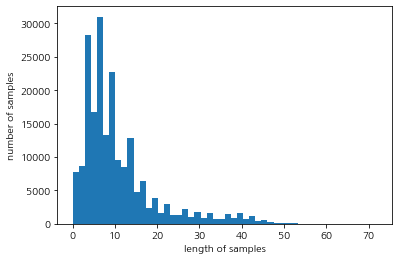

In [30]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이: ', max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이: ', sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [31]:
# Word2Vec으로 토큰화 된 네이버 영화 리뷰 데이터 학습
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [32]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

총 16,477개의 단어가 존재하며 각 단어는 100차원으로 구성되어져 있음

In [33]:
# '최민식'과 유사한 단어 뽑기
print(model.wv.most_similar("최민식"))

[('김수현', 0.8407914042472839), ('조재현', 0.825656533241272), ('안성기', 0.8150535225868225), ('이순신', 0.8142659068107605), ('이민호', 0.8129287958145142), ('크로우', 0.8121746778488159), ('송강호', 0.8114772439002991), ('홉킨스', 0.8094612956047058), ('한석규', 0.8093773126602173), ('김명민', 0.8061068654060364)]


In [34]:
# '히어로'와 유사한 단어 뽑기
print(model.wv.most_similar("히어로"))

[('무협', 0.8829634189605713), ('느와르', 0.8612462282180786), ('슬래셔', 0.8540341258049011), ('호러', 0.8348749876022339), ('블록버스터', 0.8223553895950317), ('정통', 0.8207948803901672), ('물의', 0.8111742734909058), ('무비', 0.7989484071731567), ('물', 0.7979262471199036), ('멜로', 0.7979003190994263)]


#### 사전 훈련된 Word2Vec 임베딩(Pre-trained Word2Vec embedding)
- 방대한 데이터로 사전에 훈련된 워드 임베딩을 가져와서 해당 벡터들의 값을 원하는 작업에 사용하는 방법도 있음
- 예를 들어 구글은 사전훈련된 3백만 개의 Word2Vec 단어 벡터들을 제공함 (각 임베딩 벡터의 차원은 300)
- https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit